# 1: Import Packages and Define Functions

In [1]:
# Import some libraries that will be used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import sys
sys.path.insert(1, '/Users/brianmccabe/DataScience/Flatiron/mod5/Emoji_Analysis/Scripts/')
import config
import warnings
warnings.filterwarnings('ignore')



pd.set_option('display.max_columns', 300)

%matplotlib inline

In [2]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import string
import scipy
import emoji
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brianmccabe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
def extract_emojis(s):
    return ''.join(c for c in s if c in emoji.UNICODE_EMOJI)

In [4]:
def check_for_flags(s):
    s = str(s)
    has_flag = False
    for flag in flags:
        if flag in s:
            has_flag = True
    return has_flag

In [5]:
def unique_emoji_count(s):
    return len(set([c for c in s]))

In [6]:
def condence_emojis(s):
    try:
        return set(s).pop()
    except:
        return None

In [7]:
analyzer = SentimentIntensityAnalyzer()
def sentiment_scores(s):
    return analyzer.polarity_scores(s)['compound']

In [8]:
def remove_emojis(s):
    pattern = "\w+"
    return ' '.join(re.findall(pattern, s))

# 2: Load in the Data and Clean

In [9]:
connection = mysql.connector.connect(host=config.host,
                                         user=config.user,
                                         port=config.port,
                                         password=config.password,
                                         database=config.database,
                                         auth_plugin='mysql_native_password')

cursor = connection.cursor()
query = "SELECT tweet FROM Tweets WHERE HEX(tweet) RLIKE '^(..)*F.'"

df = pd.read_sql(query, connection)

In [10]:
df['emoji'] = df.tweet.apply(extract_emojis)

In [11]:
# We can see that emoji flags have strange representations. I will remove them from the dataset.
## NOTE BELOW LIKELY WILL NO LONGER SHOW A FLAG, SINCE I'VE BEEN PULLING DATA EVERY DAY
## But, flags were basically as follows....alone as a string, they are equal to a flag plus a white space
## HOWEVER, once you strip it apart into a list form, it becomes a list of two emoticon-characters
## For example, Brazil Flag as a string is "Flag ", but as a list, it is ["[B], [R]"]
## Below, i actually acquire these codes from wikipedia to aid in removing flags from the dataset
[c for c in df.emoji.loc[9]]

['🌸']

In [12]:
import flag
from bs4 import BeautifulSoup
import requests

In [13]:
url = 'https://en.wikipedia.org/wiki/Regional_indicator_symbol'
page = requests.get(url)
soup = BeautifulSoup(page.content, 'html.parser')

In [14]:
flags = []
skip_first = 0
for item in soup.find('tbody').find_all('tr'):
    if skip_first == 0:
        skip_first += 1
        continue
    flagcode = item.find_all('td')[1].text
    flags.append(flag.flag(flagcode))

flags[0:5]    

['🇦🇨', '🇦🇩', '🇦🇪', '🇦🇫', '🇦🇬']

In [15]:
df.emoji.apply(check_for_flags).value_counts()

False    116740
True       3249
Name: emoji, dtype: int64

In [16]:
df['has_flag'] = df.emoji.apply(check_for_flags)
df = df[df.has_flag == False]
df.drop('has_flag', axis=1, inplace=True)

In [17]:
df['unique_emoji_count'] = df.emoji.apply(unique_emoji_count)

In [18]:
df['sentiment_score'] = df.tweet.apply(sentiment_scores)

In [19]:
df.to_csv("tweets_w_all_emojis_present.csv")

In [20]:
df['tweet'] = df.tweet.apply(remove_emojis)

In [21]:
df.emoji.isna().sum()

0

In [22]:
df.dropna(inplace=True)

In [23]:
df.isna().sum()

tweet                 0
emoji                 0
unique_emoji_count    0
sentiment_score       0
dtype: int64

In [24]:
df = df[df.unique_emoji_count > 0]

In [25]:
df.reset_index(inplace=True)

In [26]:
# Creating a dataframe of singular emojis to the average sentiment score they obtain
df2 = df.copy()
df2 = df2[df2.unique_emoji_count == 1]
df2['emoji'] = df2.emoji.apply(condence_emojis)
emoji_sentiment_mappings = df2[['emoji', 'sentiment_score']].groupby('emoji').mean()

In [27]:
def impute_top_emoji(s, mappings = emoji_sentiment_mappings, data = df):
    val = df[df.emoji == s].sentiment_score.values[0]
    s = list(set(s))
    closest = 100
    top = s[0]
    for i in range(0, len(s)):
        try:
            if abs(val - emoji_sentiment_mappings.loc[s[i]].sentiment_score) < closest:
                closest = abs(val - emoji_sentiment_mappings.loc[s[i]].sentiment_score)
                top = s[i]
        except:
            continue
    return top

In [28]:
df['top_emoji'] = df.emoji.apply(impute_top_emoji)

In [29]:
df.drop(["unique_emoji_count", "emoji"], axis=1, inplace=True)
df.drop('index', axis=1, inplace=True)

In [30]:
emoji_counts = dict(df.top_emoji.value_counts())

In [31]:
df['emoji_frequency'] = df.top_emoji.map(emoji_counts)

In [32]:
df.head()

,tweet,sentiment_score,top_emoji,emoji_frequency
0,Hello this has been KARINA and WINTER We re cu...,0.9840,😊,1262
1,ilysm you deserve the world please you re awes...,0.7284,🥺,3232
2,OUT OF STOCK shutterroomproductions aries__sol...,0.0000,📸,267
3,LIVE STREAMING Oleksandr Usyk vs Derek Chisora...,0.5526,🔴,306
4,Hey 965TDY I d like to hear Naughty List by li...,0.9168,😊,1262


In [33]:
df.to_csv("tweets.csv")

# 3. Explore the Data and Create Initial Insights

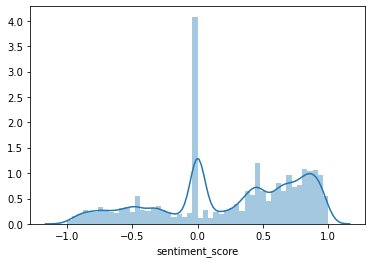

In [34]:
sns.distplot(df.sentiment_score)

In [35]:
emojis = df[df.emoji_frequency>60].groupby('top_emoji')[['sentiment_score', 'emoji_frequency']].mean()
emojis.head()

,sentiment_score,emoji_frequency
top_emoji,,
‼,-0.043559,196
⏰,-0.421920,101
☺,0.629013,92
♥,0.818117,345
⚡,-0.013098,66


In [36]:
emojis.to_csv("emojis.csv")

In [37]:
emojis.index.nunique()

241

In [38]:
emojis.emoji_frequency.describe()

count      241.000000
mean       437.788382
std        928.788167
min         61.000000
25%         92.000000
50%        171.000000
75%        444.000000
max      10106.000000
Name: emoji_frequency, dtype: float64

### Write in some blurb here about the stuff above (amount of emojis, mean freq of emoji, etc) once I have all my data

In [39]:
neg_emojis = emojis[emojis.sentiment_score < -.1].index.unique()
net_emojis = emojis[(emojis.sentiment_score >= -.1) & (emojis.sentiment_score <= .1)].index.unique()
pos_emojis = emojis[emojis.sentiment_score > .1].index.unique()

In [40]:
negative = df.loc[df['top_emoji'].isin(neg_emojis)]
neutral = df.loc[df['top_emoji'].isin(net_emojis)]
positive = df.loc[df['top_emoji'].isin(pos_emojis)]

print(f"Negative length: {len(negative)}")
print(f"Neutral length: {len(neutral)}")
print(f"Postive length: {len(positive)}")

Negative length: 18345
Neutral length: 17306
Postive length: 69856


In [41]:
negative.top_emoji.value_counts()[:15]

😭    7552
🔥    2643
👻    1600
😩     943
😢     495
😱     445
💥     444
😬     432
😡     380
😫     365
😞     307
🤬     253
🤢     243
😕     211
🤮     205
Name: top_emoji, dtype: int64

In [42]:
neutral.top_emoji.value_counts()[:15]

🙄    1419
😔    1298
🤔    1221
💀    1167
🤷    1008
🤦    1004
😳     901
🥴     853
💯     734
🙃     491
😒     488
😏     460
😐     431
😤     392
🤡     366
Name: top_emoji, dtype: int64

In [43]:
positive.top_emoji.value_counts()[:15]

😂    10106
🤣     3843
🥺     3232
🎃     2520
😍     2057
🥰     1903
🙏     1773
👀     1443
💜     1337
😊     1262
💕     1191
😁     1119
💙     1062
🚨     1050
🖤      919
Name: top_emoji, dtype: int64

From the above, I will select some emojis to have as my "target values". My model won't be able to predict any emoji from the entire list of them, as that would greatly increase the difficulty of the classification. Would likely need far, far more data than I have for each emoji in order for something like that to work.

In [44]:
test = list(negative.top_emoji.value_counts()[:10].index) \
+ list(neutral.top_emoji.value_counts()[:10].index) \
+ list(positive.top_emoji.value_counts()[:10].index)

In [45]:
test

['😭',
 '🔥',
 '👻',
 '😩',
 '😢',
 '😱',
 '💥',
 '😬',
 '😡',
 '😫',
 '🙄',
 '😔',
 '🤔',
 '💀',
 '🤷',
 '🤦',
 '😳',
 '🥴',
 '💯',
 '🙃',
 '😂',
 '🤣',
 '🥺',
 '🎃',
 '😍',
 '🥰',
 '🙏',
 '👀',
 '💜',
 '😊']

findfont: Font family ['Segoe UI Emoji'] not found. Falling back to DejaVu Sans.


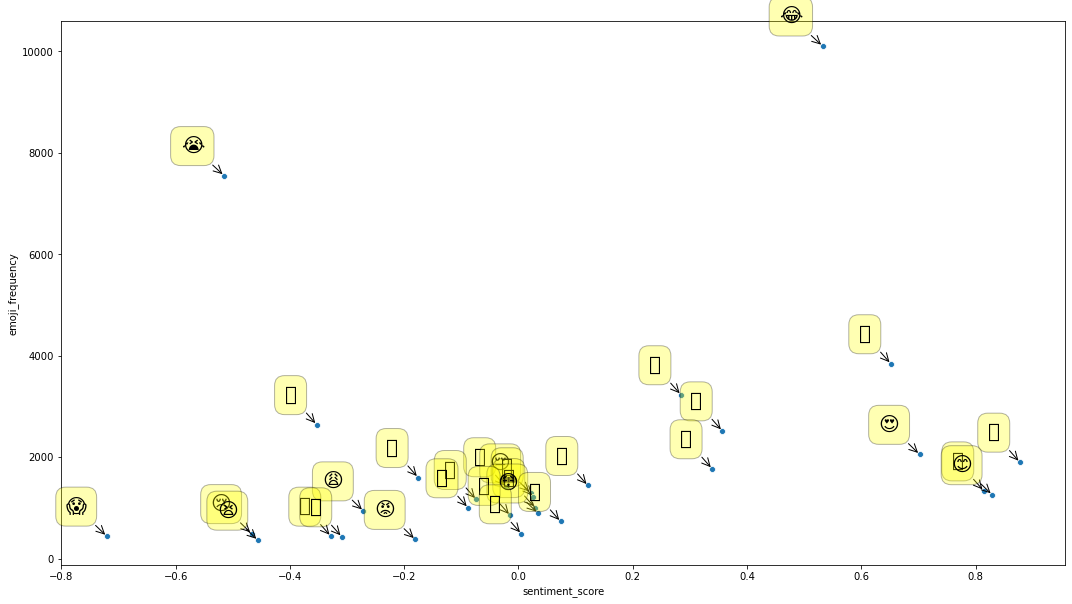

In [46]:
top30_emojis = emojis.loc[test]
plt.figure(figsize = (18,10))
sns.scatterplot(x=top30_emojis.sentiment_score, y=top30_emojis.emoji_frequency)
labels = list(top30_emojis.index)
for label, x, y in zip(labels, top30_emojis.sentiment_score, top30_emojis.emoji_frequency):
    plt.annotate(label, xy = (x, y), xytext = (-20, 20), textcoords = 'offset points', ha = 'right',
                 va = 'bottom', bbox = dict(boxstyle='round,pad=.5', fc='yellow', alpha=.3),
                 arrowprops = dict(arrowstyle='->', connectionstyle='arc3,rad=0'),
                 fontname='Segoe UI Emoji', fontsize=20)
plt.show()

In [47]:
labels[0]+'e'

'😭e'